In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape, Polygon, Point
import shapely
import os
import sys
os.chdir('./src')
from maxarseg.geoDatasets import Maxar
from maxarseg.samplers import MyGridGeoSampler
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples, unbind_samples
from maxarseg.samplers_utils import boundingBox_2_Polygon
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import cv2
import supervision as sv
import json
import time as tm

In [2]:
path = './MSRoads/data/AfricaWest-Full/AfricaWest-Full.tsv'
road_df = pd.read_csv(path, names =['country', 'geometry'] ,delimiter='\t')
country = 'GMB'
road_df = road_df[road_df['country'] == country]
road_df['geometry'] = road_df['geometry'].apply(json.loads).apply(lambda d: shape(d.get('geometry')))
road_gdf = gpd.GeoDataFrame(road_df, crs=4326)

In [3]:
dataset = Maxar('/nfs/projects/overwatch/maxar-segmentation/maxar-open-data/Gambia-flooding-8-11-2022/pre/10300100CFC9A500/033133031213.tif')
sample_size = 600
sampler = MyGridGeoSampler(dataset, size=sample_size, stride=600)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)
data_crs = dataset.crs
road_gdf_32628 = road_gdf.to_crs(data_crs)

In [4]:
sys.path.append('./models/EfficientSAM')
from efficient_sam.build_efficient_sam import build_efficient_sam_vitt, build_efficient_sam_vits
from PIL import Image
from torchvision import transforms
import torch
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Build the model.
device = 'cuda:0'
ESAM_root = './models/EfficientSAM'
efficient_sam = build_efficient_sam_vitt(os.path.join(ESAM_root, 'weights/efficient_sam_vitt.pt')).to(device)

In [6]:
from maxarseg.segment import segment_roads, rel_road_lines
dataset_res = dataset.res

road_point_dist = 40 #50
bg_point_dist = 40 #80
offset_distance = 25 #30

rnd_ix = np.random.randint(0, 50) #pick a rnd image
i = 0
for batch in dataloader:
    query_bbox_poly = boundingBox_2_Polygon(batch['bbox'][0])
    hits = road_gdf_32628.geometry.intersects(query_bbox_poly)
    queried_road_gdf_36628 = road_gdf_32628[hits]
    
    if len(queried_road_gdf_36628) > 20:
        i+=1
        if i == 2:
            sample = unbind_samples(batch)[0]
            img4Sam = sample["image"].permute(1, 2, 0).numpy().astype('uint8')
            
            road_lines = rel_road_lines(queried_road_gdf_36628, query_bbox_poly, dataset_res)
            #print(len(road_lines))

            #final_mask, final_pt_coords4Sam, final_labels4Sam = segment_roads(predictor, img4Sam, road_lines,
            #                                                                  sample_size,
            #                                                                  road_point_dist = road_point_dist,
            #                                                                  bg_point_dist = bg_point_dist,
            #                                                                  offset_distance = offset_distance,
            #                                                                  do_clean_mask=True)
            
            """plt.figure(figsize=(10,10))
            plt.imshow(img4Sam)
            show_mask(final_mask, plt.gca())
            show_points(final_pt_coords4Sam, final_labels4Sam, plt.gca())
            plotLinestrings(road_lines, plt.gca(), color = 'b') #plt road
            plt.axis('off')
            plt.gca().set_xlim([0, sample_size])
            plt.gca().set_ylim([sample_size, 0])
            plt.show()"""
            break


In sampler
tile_polygon:  POLYGON ((320156.25 1489843.75, 315455.322265625 1489843.75, 315470.63516642543 1492342.8892077415, 320156.25 1491748.5059546148, 320156.25 1489843.75))


### Single Road prediction

In [7]:
from maxarseg.segment import line2points, rmv_pts_out_img, get_offset_lines, clear_roads
road_idx = 8 #pick a road
final_pt_coords4Sam = []
final_labels4Sam = []


road = road_lines[road_idx] #pick a road
road_pts = line2points(road, road_point_dist) #turn the road into a list of shapely points
np_roads_pts = np.array([list(pt.coords)[0] for pt in road_pts]) #turn the shapely points into a numpy array
np_roads_pts = rmv_pts_out_img(np_roads_pts, sample_size) #remove road points outside the image
np_road_labels = np.array([1]*np_roads_pts.shape[0]) #create the labels for the road points

bg_lines = get_offset_lines(road, offset_distance) #create two offset lines from the road
bg_pts = line2points(bg_lines, bg_point_dist) #turn the offset lines into a list of shapely points
bg_pts = clear_roads(road_lines, bg_pts, offset_distance - 4) #remove bg points that may be on other roads
np_bg_pts = np.array([list(pt.coords)[0] for pt in bg_pts]) #turn the shapely points into a numpy array
np_bg_pts = rmv_pts_out_img(np_bg_pts, sample_size) #remove road points outside the image
np_bg_labels = np.array([0]*np_bg_pts.shape[0]) #create the labels for the bg points

pt_coords4Sam = np.concatenate((np_roads_pts, np_bg_pts)) #tmp list
labels4Sam = np.concatenate((np_road_labels, np_bg_labels))

final_pt_coords4Sam.extend(pt_coords4Sam.tolist()) #global list
final_labels4Sam.extend(labels4Sam.tolist()) #global list
print(final_pt_coords4Sam)
print(final_labels4Sam)


[[540.2363337659835, 91.76209739837647], [500.3366182629826, 88.93142560892716], [460.4369027599816, 86.10075381947783], [420.53718725698064, 83.27008203002852], [380.63747175397964, 80.43941024057919], [340.7377562509787, 77.60873845112988], [300.83804074797774, 74.77806666168057], [260.93832524497674, 71.94739487223124], [221.0386097419758, 69.11672308278193], [422.30635712538646, 58.33275984065291], [219.26943987356998, 94.05404527215754], [338.9685863825729, 102.54606064050549], [542.0055036343894, 66.82477520900086], [342.5069261193845, 52.671416261754274], [458.6677328915758, 111.03807600885344], [299.06887087957193, 99.71538885105618], [262.70749511338255, 47.010072682855636], [302.60721061638355, 49.84074447230496], [222.8077796103816, 44.179400893406324], [498.5674483945768, 113.86874779830276], [462.2060726283874, 61.163431630102224], [259.1691553765709, 96.88471706160685], [378.8683018855738, 105.3767324299548], [382.40664162238545, 55.50208805120359], [502.1057881313884, 63

In [8]:
len(final_pt_coords4Sam)

26

In [9]:
input_points = torch.tensor(final_pt_coords4Sam, device=device)[None, None, ...]
print(input_points.shape)
input_labels = torch.tensor(final_labels4Sam, device=device)[None, None, ...] #[B, max_num_queries, num_pts]
print(input_labels.shape)

torch.Size([1, 1, 26, 2])
torch.Size([1, 1, 26])


In [10]:
sample_image_np = img4Sam
sample_image_tensor = transforms.ToTensor()(sample_image_np)
sample_image_tensor = sample_image_tensor.to(device)
print('sample_image_tensor:', sample_image_tensor.shape)
batched_images = sample_image_tensor.unsqueeze(0)
batch_size, _, input_h, input_w = batched_images.shape
image_embeddings = efficient_sam.get_image_embeddings(batched_images)

sample_image_tensor: torch.Size([3, 600, 600])


In [11]:
end_idx = 70
predicted_logits, predicted_iou = efficient_sam.predict_masks(image_embeddings,
                                                input_points[:, : end_idx],
                                                input_labels[:, : end_idx],
                                                multimask_output=True,
                                                input_h = input_h,
                                                input_w = input_w,
                                                output_h=input_h,
                                                output_w=input_w)

In [12]:
predicted_logits.shape

torch.Size([1, 1, 3, 600, 600])

In [13]:
np_complete_masks = predicted_logits[:,:,0].cpu().detach().numpy()
np_complete_masks.shape

(1, 1, 600, 600)

In [14]:
np_final_mask = np.greater_equal(np_complete_masks, 0).any(axis=1)
np_final_mask.shape

(1, 600, 600)

In [15]:
from maxarseg.plotting_utils import show_mask
    
def plot_w_wo_masks_ESAM(img, masks, building_boxes = None):
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(img)

    ax2 = fig.add_subplot(1, 2, 2, sharex=ax1, sharey=ax1)
    ax2.imshow(img)
    if masks.ndim == 2:
        masks = masks[np.newaxis, ...]
    for mask in masks:
        show_mask(mask, ax2)
    if building_boxes is not None:
        for box in building_boxes:
            x0, y0 = box[0], box[1]
            w, h = box[2] - box[0], box[3] - box[1]
            rect = patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='r', facecolor='none')            
            ax2.add_patch(rect)
    
    ax2.set_xlim([0, img.shape[1]])
    ax2.set_ylim([img.shape[0], 0])

    ax1.axis('off')
    ax2.axis('off')

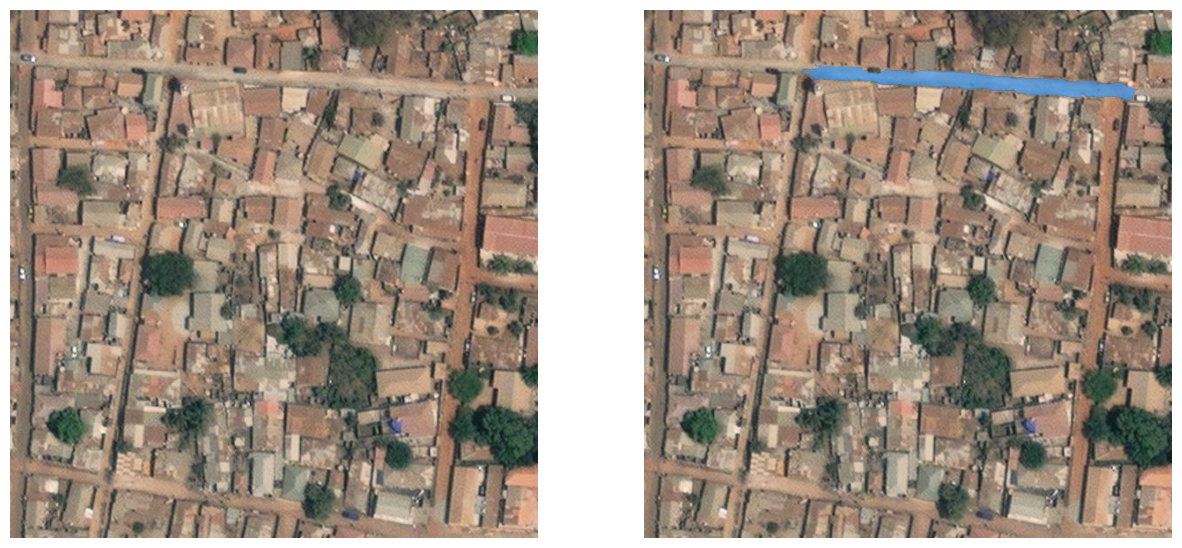

In [16]:
plot_w_wo_masks_ESAM(sample_image_np, np_final_mask[0])

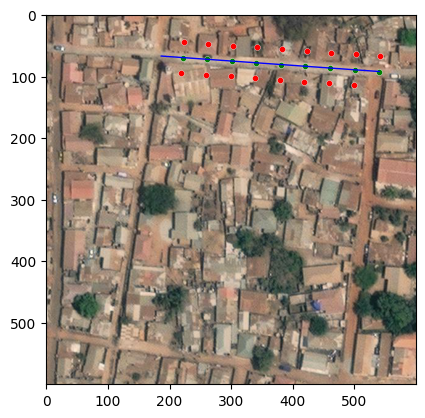

In [17]:
from maxarseg.plotting_utils import show_Linestrings, show_points
plt.imshow(img4Sam)
show_points(pt_coords4Sam, labels4Sam, plt.gca())
show_Linestrings(road_lines[road_idx], ax = plt.gca(), color = 'b')

### All road prediction (using batch)

In [18]:
final_pt_coords4Sam = []
final_labels4Sam = []
max_num_points = 0
for road in road_lines:

    road_pts = line2points(road, road_point_dist) #turn the road into a list of shapely points
    np_roads_pts = np.array([list(pt.coords)[0] for pt in road_pts]) #turn the shapely points into a numpy array
    np_roads_pts = rmv_pts_out_img(np_roads_pts, sample_size) #remove road points outside the image
    np_road_labels = np.array([1]*np_roads_pts.shape[0]) #create the labels for the road points
    if len(np_road_labels) < 2:
        continue

    bg_lines = get_offset_lines(road, offset_distance) #create two offset lines from the road
    bg_pts = line2points(bg_lines, bg_point_dist) #turn the offset lines into a list of shapely points
    bg_pts = clear_roads(road_lines, bg_pts, offset_distance - 4) #remove bg points that may be on other roads
    np_bg_pts = np.array([list(pt.coords)[0] for pt in bg_pts]) #turn the shapely points into a numpy array
    np_bg_pts = rmv_pts_out_img(np_bg_pts, sample_size) #remove road points outside the image
    np_bg_labels = np.array([0]*np_bg_pts.shape[0]) #create the labels for the bg points
    if len(np_bg_labels) == 0: #if there are no bg_points or 0 or 1 road points skip the road
        continue
    pt_coords4Sam = np.concatenate((np_roads_pts, np_bg_pts)) #tmp list
    labels4Sam = np.concatenate((np_road_labels, np_bg_labels))
    if len(labels4Sam) > max_num_points:
        max_num_points = len(labels4Sam)

    final_pt_coords4Sam.append(pt_coords4Sam.tolist()) #global list
    final_labels4Sam.append(labels4Sam.tolist()) #global list


In [19]:
from copy import deepcopy
#labels
copy_final_labels4Sam = deepcopy(final_labels4Sam)
[l.extend([0]*(max_num_points-len(l))) for l in copy_final_labels4Sam]
np_final_labels4Sam = np.array(copy_final_labels4Sam)
print(np_final_labels4Sam.shape)

#points
copy_final_pt_coords4Sam = deepcopy(final_pt_coords4Sam)
[l_ext.extend([[-30,-30]]*(max_num_points-len(l_ext))) for l_ext in copy_final_pt_coords4Sam]
#np_final_pt_coords4Sam = np.array(copy_final_pt_coords4Sam)
#print(np_final_pt_coords4Sam.shape)

(21, 26)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [20]:
input_points = torch.tensor(copy_final_pt_coords4Sam, device=device)[None, ...]
input_labels = torch.tensor(copy_final_labels4Sam, device=device)[None, ...]
print(input_points.shape)
print(input_labels.shape)

torch.Size([1, 21, 26, 2])
torch.Size([1, 21, 26])


In [21]:
predicted_logits, predicted_iou = efficient_sam.predict_masks(image_embeddings,
                                                            input_points[:, :],
                                                            input_labels[:, :],
                                                            multimask_output=True,
                                                            input_h = input_h,
                                                            input_w = input_w,
                                                            output_h=input_h,
                                                            output_w=input_w)

In [22]:
predicted_logits.shape

torch.Size([1, 21, 3, 600, 600])

In [23]:
np_complete_masks = predicted_logits[:,:,0].cpu().detach().numpy()
np_complete_masks.shape

(1, 21, 600, 600)

In [24]:
np_final_mask = np.greater_equal(np_complete_masks, 0).any(axis=1)
np_final_mask.shape

(1, 600, 600)

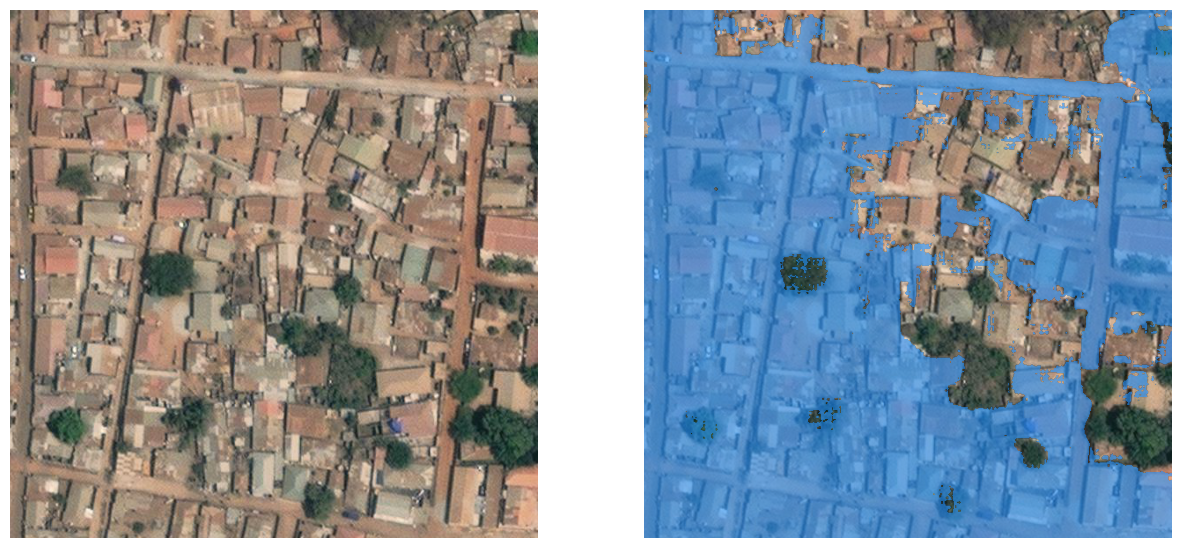

In [25]:
plot_w_wo_masks_ESAM(sample_image_np, np_final_mask[0])

In [26]:
from maxarseg.segment import clean_mask
final_mask = clean_mask(road_lines, np_final_mask[0], offset_distance - 10)

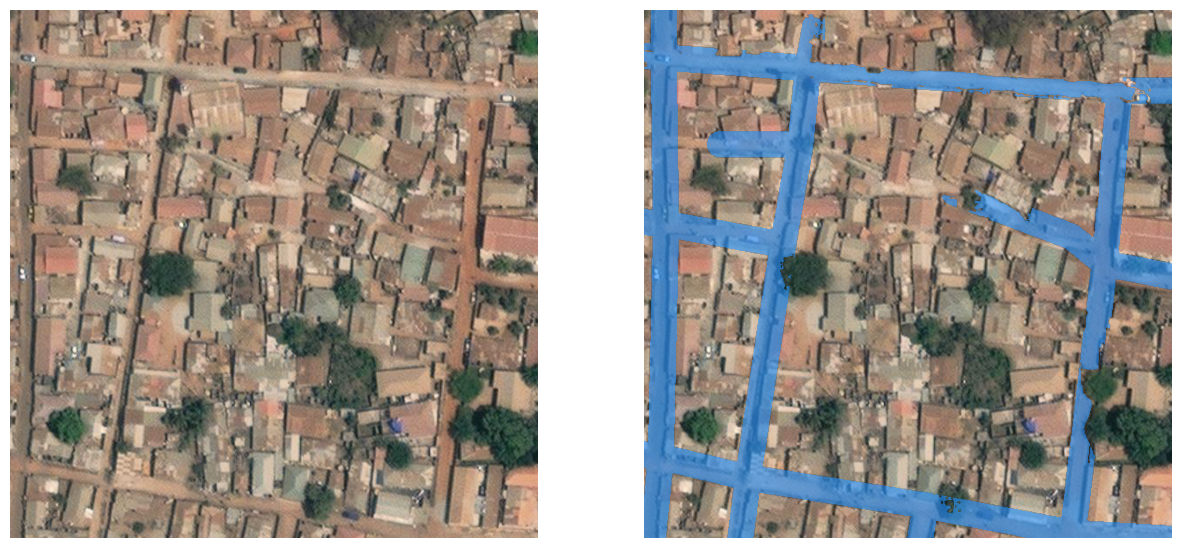

In [27]:
plot_w_wo_masks_ESAM(sample_image_np, final_mask)

### All road prediction using for loop

In [74]:
final_pt_coords4Sam = []
final_labels4Sam = []
max_num_points = 0
for i, road in enumerate(road_lines):

    road_pts = line2points(road, road_point_dist) #turn the road into a list of shapely points
    np_roads_pts = np.array([list(pt.coords)[0] for pt in road_pts]) #turn the shapely points into a numpy array
    np_roads_pts = rmv_pts_out_img(np_roads_pts, sample_size) #remove road points outside the image
    np_road_labels = np.array([1]*np_roads_pts.shape[0]) #create the labels for the road points
    if len(np_road_labels) < 2:
        continue

    bg_lines = get_offset_lines(road, offset_distance) #create two offset lines from the road
    bg_pts = line2points(bg_lines, bg_point_dist) #turn the offset lines into a list of shapely points
    bg_pts = clear_roads(road_lines, bg_pts, offset_distance - 4) #remove bg points that may be on other roads
    np_bg_pts = np.array([list(pt.coords)[0] for pt in bg_pts]) #turn the shapely points into a numpy array
    np_bg_pts = rmv_pts_out_img(np_bg_pts, sample_size) #remove road points outside the image
    np_bg_labels = np.array([0]*np_bg_pts.shape[0]) #create the labels for the bg points
    if len(np_bg_labels) == 0: #if there are no bg_points or 0 or 1 road points skip the road
        continue
    pt_coords4Sam = np.concatenate((np_roads_pts, np_bg_pts)) #tmp list
    labels4Sam = np.concatenate((np_road_labels, np_bg_labels))
    if len(labels4Sam) > max_num_points:
        max_num_points = len(labels4Sam)

    #final_pt_coords4Sam.append(pt_coords4Sam.tolist()) #global list
    #final_labels4Sam.append(labels4Sam.tolist()) #global list

    input_points = torch.tensor(pt_coords4Sam, device=device)[None, None, ...]
    #print(input_points.shape)
    input_labels = torch.tensor(labels4Sam, device=device)[None, None, ...] #[B, max_num_queries, num_pts]
    #print(input_labels.shape)
    predicted_logits, predicted_iou = efficient_sam.predict_masks(image_embeddings,
                                                input_points[:, :],
                                                input_labels[:, :],
                                                multimask_output=True,
                                                input_h = input_h,
                                                input_w = input_w,
                                                output_h=input_h,
                                                output_w=input_w)
    
    if i == 0:
        np_complete_masks = predicted_logits[:,:,0].cpu().detach().numpy()
        print(np_complete_masks.shape)
    
    else:
        np_complete_masks = np.concatenate((np_complete_masks, predicted_logits[:,:,0].cpu().detach().numpy()), axis = 1)



(1, 1, 600, 600)


In [68]:
np_complete_masks.shape

(1, 23, 600, 600)

In [72]:
np_final_mask = np.greater_equal(np_complete_masks, 0).any(axis=1)
np_final_mask.shape

(1, 600, 600)

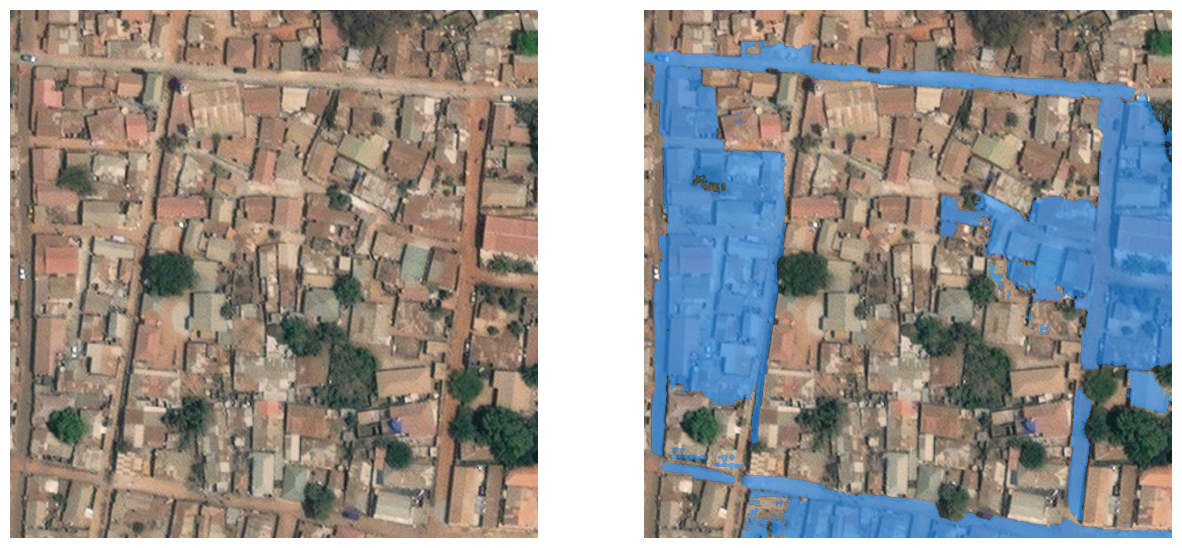

In [73]:
plot_w_wo_masks_ESAM(sample_image_np, np_final_mask[0])

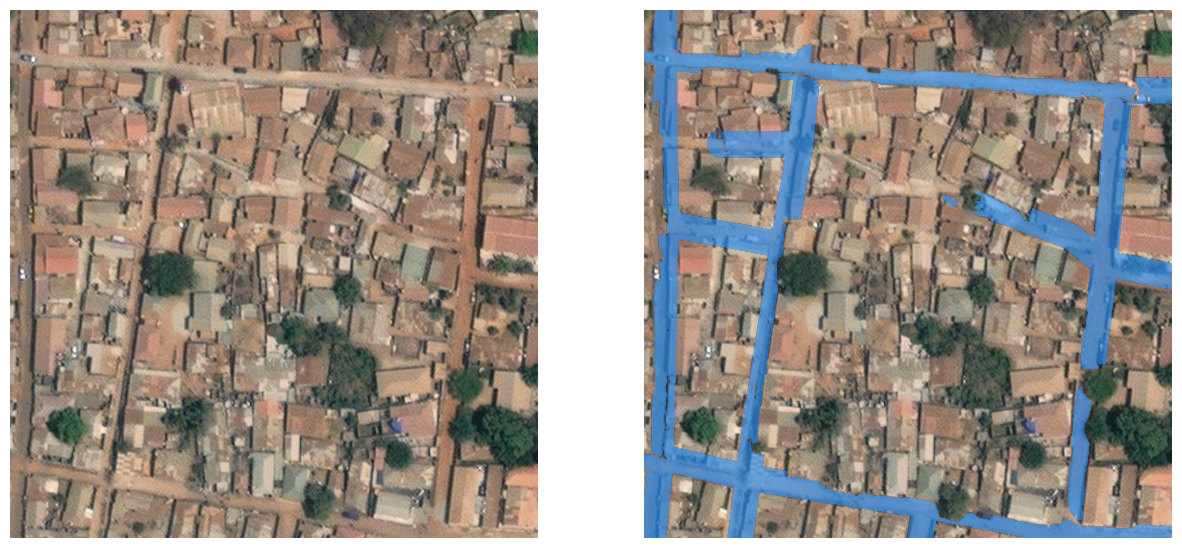

In [32]:
plot_w_wo_masks_ESAM(sample_image_np, clean_mask(road_lines, np_final_mask[0], offset_distance - 10))

In [17]:
from road_seg_utils import rel_road_lines, line2points, get_offset_lines, clear_roads, plotLinestrings, plotPoints, rmv_pts_out_img

In [61]:
road_input_points = []
bg_input_points = []

positive_input_labels = []
negative_input_labels = []

all_input_points = []
all_input_labels = []

print(len(road_lines))
max = 0
for road in road_lines:
    road_pts = line2points(road, road_point_dist) #turn the road into a list of shapely points
    np_roads_pts = np.array([list(pt.coords)[0] for pt in road_pts]) #turn the shapely points into a numpy array
    np_roads_pts = rmv_pts_out_img(np_roads_pts, sample_size) #remove road points outside the image
    if len(np_roads_pts) > max:
        max = len(np_roads_pts)

    all_input_points.append(np_roads_pts.tolist())
    all_input_labels.append([1]*(np_roads_pts.shape[0]))
    
    np_road_labels = np.array([1]*np_roads_pts.shape[0])
    
    bg_lines = get_offset_lines(road, offset_distance) #create two offset lines from the road
    bg_pts = line2points(bg_lines, bg_point_dist) #turn the offset lines into a list of shapely points
    bg_pts = clear_roads(road_lines, bg_pts, offset_distance - 4) #remove bg points that may be on other roads
    np_bg_pts = np.array([list(pt.coords)[0] for pt in bg_pts])
    np_bg_pts = rmv_pts_out_img(np_bg_pts, sample_size)
    
    all_input_points.append(np_bg_pts.tolist())
    all_input_labels.append([0]*(np_bg_pts.shape[0]))

    np_bg_labels = np.array([0]*np_bg_pts.shape[0])
    
    if len(np_bg_labels) == 0 or len(np_road_labels) < 2: #if there are no bg_points or 0 or 1 road points skip the road
        continue

print(max)

13
9


In [63]:
len(all_input_points)

26

In [58]:
road_input_points[:3]

[[[480.60842210922243, 308.7360828163147],
  [442.0065560801419, 319.21920921414653],
  [403.4046900510614, 329.7023356119783],
  [364.8028240219808, 340.1854620098101],
  [326.20095799290027, 350.66858840764195],
  [287.5990919638198, 361.1517148054737]],
 [[377.9890218464307, 12.86829488065083],
  [391.0966683651789, 50.65969076304116],
  [404.20431488392705, 88.45108664543147],
  [417.31196140267525, 126.24248252782183],
  [430.41960792142345, 164.03387841021214],
  [443.52725444017165, 201.82527429260247],
  [456.63490095891984, 239.6166701749928],
  [469.74254747766804, 277.40806605738317]],
 [[290.0636716082985, 3.401997588706145],
  [252.65481974860643, 17.56454688392897],
  [215.2459678889144, 31.727096179151793],
  [177.8371160292224, 45.889645474374625]]]

In [38]:
#for list_road_pt in road_input_points:
#    list_road_pt.extend([[-1,-1]]*(max - len(list_road_pt)))

In [53]:
positive_input_labels

[[1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1],
 [1, 1, 1],
 [1, 1, 1, 1, 1, 1],
 [1],
 [1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1],
 [1],
 [],
 [1, 1, 1, 1, 1, 1, 1, 1]]

In [59]:
bg_input_points

[[[332.75291199154515, 374.7947546758173],
  [358.25087002333595, 316.0592957416348],
  [281.0471379651749, 337.0255485372984],
  [409.95664404970626, 353.8285018801536],
  [396.8527360524165, 305.576169343803],
  [294.15104596246465, 385.27788107364904],
  [319.6490039942554, 326.5424221394666],
  [448.55851007878675, 343.34537548232186],
  [435.454602081497, 295.0930429459712],
  [371.3547780206257, 364.31162827798545]],
 [[493.362169904162, 269.2157869831656],
  [467.1468768666656, 193.63299521838485],
  [393.6923389761813, 134.43476160203943],
  [454.0392303479174, 155.84159933599452],
  [380.5846924574331, 96.6433657196491],
  [401.60864427292466, 4.676015806433213],
  [427.823937310421, 80.25880757121386],
  [414.71629079167286, 42.467411688823546],
  [367.47704593868497, 58.85196983725878],
  [433.0152785324259, 247.8089492492104],
  [419.9076320136777, 210.0175533668201],
  [354.36939941993677, 21.060573954868445],
  [406.7999854949295, 172.22615748442973],
  [480.2545233854138

In [60]:
negative_input_labels

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0],
 [],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [46]:
print(len(road_input_points), '\n')
for road in road_input_points:
    print(len(road))
    positive_input_labels

13 

6
8
4
3
6
1
4
7
9
3
1
0
8


In [ ]:
E_SAM_inpu_pts = #positive + negative points

In [48]:
positive_pt = road_input_points
positive_pt

[[[480.60842210922243, 308.7360828163147],
  [442.0065560801419, 319.21920921414653],
  [403.4046900510614, 329.7023356119783],
  [364.8028240219808, 340.1854620098101],
  [326.20095799290027, 350.66858840764195],
  [287.5990919638198, 361.1517148054737]],
 [[377.9890218464307, 12.86829488065083],
  [391.0966683651789, 50.65969076304116],
  [404.20431488392705, 88.45108664543147],
  [417.31196140267525, 126.24248252782183],
  [430.41960792142345, 164.03387841021214],
  [443.52725444017165, 201.82527429260247],
  [456.63490095891984, 239.6166701749928],
  [469.74254747766804, 277.40806605738317]],
 [[290.0636716082985, 3.401997588706145],
  [252.65481974860643, 17.56454688392897],
  [215.2459678889144, 31.727096179151793],
  [177.8371160292224, 45.889645474374625]],
 [[473.95909080162363, 596.5592328607099],
  [513.0609819482845, 588.1305847630206],
  [552.1628730949454, 579.7019366653312]],
 [[342.8479696434915, 584.3030726136561],
  [329.04252192534204, 546.7609680735343],
  [315.2370

In [43]:
positive_labels = np.array([1]*positive_pt.shape[0])
positive_labels.shape

(13,)

In [18]:
def segment_roads(predictor, img4Sam, road_lines, sample_size, road_point_dist = 50, bg_point_dist = 80, offset_distance = 50, do_clean_mask = True):
    
    #initialize an empty mask
    final_mask = np.full((sample_size, sample_size), False)
    
    final_pt_coords4Sam = []
    final_labels4Sam = []
    
    for road in road_lines:
        road_pts = line2points(road, road_point_dist) #turn the road into a list of shapely points
        np_roads_pts = np.array([list(pt.coords)[0] for pt in road_pts]) #turn the shapely points into a numpy array
        np_roads_pts = rmv_pts_out_img(np_roads_pts, sample_size) #remove road points outside the image
        np_road_labels = np.array([1]*np_roads_pts.shape[0])
        
        bg_lines = get_offset_lines(road, offset_distance) #create two offset lines from the road
        bg_pts = line2points(bg_lines, bg_point_dist) #turn the offset lines into a list of shapely points
        bg_pts = clear_roads(road_lines, bg_pts, offset_distance - 4) #remove bg points that may be on other roads
        np_bg_pts = np.array([list(pt.coords)[0] for pt in bg_pts])
        np_bg_pts = rmv_pts_out_img(np_bg_pts, sample_size)
        np_bg_labels = np.array([0]*np_bg_pts.shape[0])

        if len(np_bg_labels) == 0 or len(np_road_labels) < 2: #if there are no bg_points or 0 or 1 road points skip the road
            continue

        pt_coords4Sam = np.concatenate((np_roads_pts, np_bg_pts))
        labels4Sam = np.concatenate((np_road_labels, np_bg_labels))

        final_pt_coords4Sam.extend(pt_coords4Sam.tolist())
        final_labels4Sam.extend(labels4Sam.tolist())

        mask, _, _ = predictor.predict(
                point_coords=pt_coords4Sam,
                point_labels=labels4Sam,
                multimask_output=False,
            )
        final_mask = np.logical_or(final_mask, mask[0])

    if do_clean_mask:
        final_mask = clean_mask(road_lines, final_mask, offset_distance - 10) #TODO: eventualmente aggiungere un parametro per l'additional_cleaning       
    
    return final_mask[np.newaxis, :], np.array(final_pt_coords4Sam), np.array(final_labels4Sam)